# Data preparation and exploration

We prepare the KLIFS dataset to be used for `kissim` encoding and comparison.

- Fetch all structures in KLIFS (metadata).
- Filter dataset by
  - Species
  - DFG conformation (optional)
  - Resolution
  - Quality score
  - Best struture per kinase-PDB pair
- Save the KLIFS structure IDs for the filtered dataset.

__Note__: The KLIFS data is prepared only on the basis of the structures' metadata from KLIFS. Additional filtering will happen during fingerprint generation, where the actual structural data (coordiantes ect.) are used.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import logging

import pandas as pd
from opencadd.databases.klifs import setup_remote

from src.data.structures import filters, explorer

In [3]:
logging.basicConfig(level=logging.INFO)
pd.set_option("display.max_columns", 50)

In [4]:
SPECIES = "Human"
RESOLUTION_MAX = 4
QUALITYSCORE_MIN = 4

HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/processed/"

## Fetch structures (metadata)

In [5]:
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [6]:
structures = remote.structures.all_structures()
print(structures.shape)
structures.head()

(12465, 41)


,structure.klifs_id,structure.pdb_id,structure.alternate_model,structure.chain,species.klifs,kinase.klifs_id,kinase.klifs_name,kinase.family,kinase.group,structure.pocket,ligand.expo_id,ligand_allosteric.expo_id,ligand.name,ligand_allosteric.name,structure.dfg,structure.ac_helix,structure.resolution,structure.qualityscore,structure.missing_residues,structure.missing_atoms,structure.rmsd1,structure.rmsd2,structure.front,structure.gate,structure.back,structure.fp_i,structure.fp_ii,structure.bp_i_a,structure.bp_i_b,structure.bp_ii_in,structure.bp_ii_a_in,structure.bp_ii_b_in,structure.bp_ii_out,structure.bp_ii_b,structure.bp_iii,structure.bp_iv,structure.bp_v,structure.grich_distance,structure.grich_angle,structure.grich_rotation,structure.filepath
0,2543,4gv1,A,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,0XZ,-,<NA>,<NA>,in,in,1.49,8.0,0,0,0.778,2.095,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,17.830900,58.416401,58.960499,<NA>
1,2537,3mv5,A,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,XFE,-,<NA>,<NA>,in,in,2.47,8.0,0,0,0.779,2.092,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,17.396900,57.091900,55.166599,<NA>
2,2536,4gv1,B,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,0XZ,-,<NA>,<NA>,in,in,1.49,8.0,0,0,0.778,2.095,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,17.830900,58.351101,58.960602,<NA>
3,2535,3qkk,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKILHTLTENRVLQNSRPFLTALKYSCFVME...,SMH,-,<NA>,<NA>,in,in,2.30,8.0,0,0,0.779,2.103,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,18.656799,59.938599,58.083000,<NA>
4,10913,6hhi,-,A,Human,1,AKT1,<NA>,<NA>,KLLGKGTFGKVILYAMKIL_________QNSRPFLTALKYSCFVME...,G4N,-,<NA>,<NA>,out,na,2.70,3.2,9,0,0.959,2.376,False,False,True,False,False,False,False,False,False,False,True,False,True,True,False,20.028200,66.834602,57.757599,<NA>


## Explore structures in full dataset

### Species, DFG/aC-helix conformations, ligand

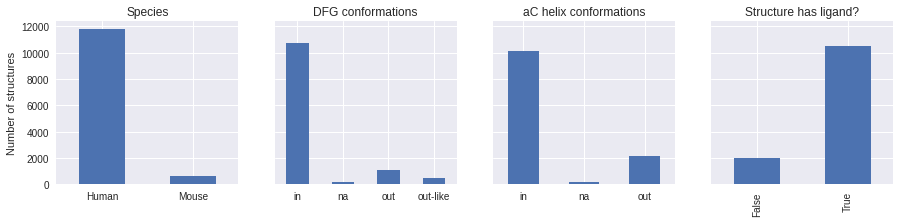

In [7]:
explorer.plot_important_categories(structures);

### Resolution vs. quality score

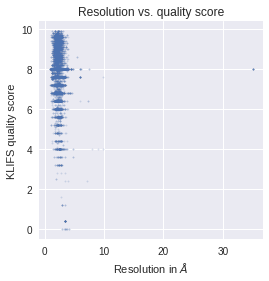

In [8]:
explorer.plot_resolution_vs_qualityscore(structures);

### Number of structures per kinase-PDB pair

How many kinase-PDB pairs are represented by how many structures?

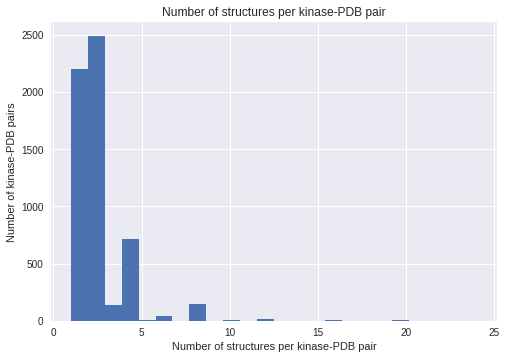

In [9]:
explorer.plot_number_of_structures_per_kinase_pdb_pair(structures);

## Filter and save structures

### DFG-all

In [10]:
structures_filtered = (
    structures.pipe(filters.make_copy)
    .pipe(filters.select_species, SPECIES)
    # .pipe(filters.select_dfg, DFG_CONFORMATION)
    .pipe(filters.select_resolution, RESOLUTION_MAX)
    .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
    .pipe(filters.select_best_pdb_kinase_pairs)
)
structures_filtered.reset_index(inplace=True, drop=True)
structures_filtered["structure.klifs_id"].sort_values().to_csv(
    DATA / "structure_klifs_ids.txt", index=None, header=None
)

INFO:src.data.structures.filters:make_copy                       12465 structures (-1 day, 23:59:59.994200s)
INFO:src.data.structures.filters:select_species                  11800 structures (-1 day, 23:59:59.990565s)
INFO:src.data.structures.filters:select_resolution               11511 structures (-1 day, 23:59:59.990997s)
INFO:src.data.structures.filters:select_qualityscore             11421 structures (-1 day, 23:59:59.987949s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     5305 structures (-1 day, 23:59:59.968961s)


### DFG-in / DFG-out

In [11]:
for dfg_conformation in ["in", "out"]:
    structures_filtered = (
        structures.pipe(filters.make_copy)
        .pipe(filters.select_species, SPECIES)
        .pipe(filters.select_resolution, RESOLUTION_MAX)
        .pipe(filters.select_qualityscore, QUALITYSCORE_MIN)
        .pipe(filters.select_dfg, dfg_conformation)
        .pipe(filters.select_best_pdb_kinase_pairs)
    )
    structures_filtered.reset_index(inplace=True, drop=True)
    structures_filtered["structure.klifs_id"].sort_values().to_csv(
        DATA / f"structure_klifs_ids_dfg_{dfg_conformation}.txt", index=None, header=None
    )

INFO:src.data.structures.filters:make_copy                       12465 structures (-1 day, 23:59:59.994516s)
INFO:src.data.structures.filters:select_species                  11800 structures (-1 day, 23:59:59.989784s)
INFO:src.data.structures.filters:select_resolution               11511 structures (-1 day, 23:59:59.991742s)
INFO:src.data.structures.filters:select_qualityscore             11421 structures (-1 day, 23:59:59.991784s)
INFO:src.data.structures.filters:select_dfg                       9949 structures (-1 day, 23:59:59.991433s)
INFO:src.data.structures.filters:select_best_pdb_kinase_pairs     4595 structures (-1 day, 23:59:59.976130s)
INFO:src.data.structures.filters:make_copy                       12465 structures (-1 day, 23:59:59.992917s)
INFO:src.data.structures.filters:select_species                  11800 structures (-1 day, 23:59:59.989743s)
INFO:src.data.structures.filters:select_resolution               11511 structures (-1 day, 23:59:59.992302s)
INFO:src.data.struc